# NLP classification - supervised learning

In this example, you will learn how you can use supervised learning algorithms for NLP classification. We will use documents from mtsamples again. The task is to classify a document into its clinical specialty, e.g. pediatrics or hematology.

We will use classification algorithms as implemented in sci-kit learn, and evaluate with cross-validation before testing on unseen test data.

We will experiment with different ways of representing the documents for the classifiers.

material in parts from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

Written by Sumithra Velupillai, March 2019 - updated February 2020

# 1: Packages
We will use a number of different packages for this exercise

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
try:
    import xlrd
except ImportError as e:
    !pip install xlrd
    import xlrd

import numpy as np

import warnings; warnings.simplefilter('ignore')


In [2]:
# We'll use scikit-learn for the classification algorithms.
# https://scikit-learn.org/stable/

#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [3]:
## sklearn also has some nice funtions for representations

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## and for evaluation
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score



In [4]:
## Since we're working with text, we might need to tokenize for some of these representations. 
# We'll use nltk here, but there are other nlp packages available for this
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords







[nltk_data] Downloading package punkt to /Users/angus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/angus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# You have also learnt about embedding representations. These can also be used for classification.
# We will use a library called Zeugma, which allows using pre-trained embedding models
#Zeugma library: https://github.com/nkthiebaut/zeugma

try:
    from zeugma.embeddings import EmbeddingTransformer
except ImportError as e:
    !pip install zeugma
    !pip install theano
    from zeugma.embeddings import EmbeddingTransformer

from datetime import datetime
print(datetime.now())

2021-05-27 08:59:43.618375


# 2: Corpus
Read in the training data.

In [34]:

#xlds_training = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_trainingdata.xlsx?raw=true'
#trainingdata = pd.read_excel(xlds_training)

#labelMap = {"METHODS":"NOTCONC",
#            "RESULTS":"NOTCONC",
#            "CONCLUSIONS":"CONCLUSIONS",
#            "BACKGROUND":"NOTCONC",
#            "OBJECTIVE":"NOTCONC"
#           }

trainingdata = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
#trainingdata['label2'] = trainingdata['label'].map(labelMap)

Take a look at the content of the training data. What are we trying to classify? What are the labels we want to try to learn? How many instances do we have?

In [37]:
trainingdata['label'].value_counts()

METHODS        8293
RESULTS        8142
CONCLUSIONS    3754
BACKGROUND     2852
OBJECTIVE      1959
Name: label, dtype: int64

What types of features do you think would be useful for the classification task? Where can we get them? Take a look at one or two of the documents. Can you guess which classification label these belong to?

In [38]:
trainingtxt_example = trainingdata['txt'].tolist()[0]
print(trainingtxt_example)

IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .


In [39]:
trainingtxt_example = trainingdata['txt'].tolist()[231]
print(trainingtxt_example)

Patients were randomly allocated into three equal groups : The fentanyl group received 100 mL of IV normal saline as a placebo , with the first dose ending 30 min before intubation .


# 3: Representation - BoW

The most common baseline feature representation for text classification tasks is to use the *bag-of-words* representation, in a document-term matrix. Let's build a simple one using raw counts and only keeping a maximum of 500 features. We can use the CountVectorizer function from sklearn, and tokenize using a function from nltk.

In [40]:
first_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
first_vectorizer.fit(trainingdata['txt'].tolist())
first_fit_transformed_data = first_vectorizer.fit_transform(trainingdata['txt'])


We can now look at this transformed representation for an example document.

In [41]:
first_transformed_data = first_vectorizer.transform([trainingdata['txt'].tolist()[231]])
print (first_transformed_data)

  (0, 7)	1
  (0, 9)	1
  (0, 19)	1
  (0, 32)	1
  (0, 45)	1
  (0, 53)	1
  (0, 75)	1
  (0, 91)	1
  (0, 104)	1
  (0, 176)	1
  (0, 210)	1
  (0, 229)	1
  (0, 230)	1
  (0, 269)	1
  (0, 301)	1
  (0, 303)	1
  (0, 323)	1
  (0, 341)	1
  (0, 348)	1
  (0, 373)	1
  (0, 379)	1
  (0, 441)	2
  (0, 450)	1
  (0, 486)	1
  (0, 494)	1


What word is represented by the different indices? Have a look at a few examples.

In [42]:
print (first_vectorizer.get_feature_names()[440])

that


In [43]:
print(first_fit_transformed_data.shape)
print ('Amount of Non-Zero occurences: ', first_fit_transformed_data.nnz)

(25000, 500)
Amount of Non-Zero occurences:  358396


# 4: Classification
Let's build a classifier with this feature representation. In text classification, many classification algorithms have been shown to work well. Sci-kit learn has implementations for many different types of classification algorithms - have a look at their website!

Let's try a K nearest neighbour classifier.


In [45]:
kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['label'])

We now have a trained model. But how do we know how well it works? Let's evaluate it on the test data.

In [46]:

#xlds_test = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_test_data.xlsx?raw=true'
#testdata = pd.read_excel(xlds_test)

testdata = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
#testdata['label2'] = testdata['label'].map(labelMap)


## We need to transform this data to the same representation
first_fit_transformed_testdata = first_vectorizer.transform(testdata['txt'])

In [47]:
first_fit_transformed_testdata
kneighbour_predicted = kneighbour_classifier.predict(first_fit_transformed_testdata)
kneighbour_predicted

array(['BACKGROUND', 'CONCLUSIONS', 'CONCLUSIONS', ..., 'RESULTS',
       'METHODS', 'CONCLUSIONS'], dtype=object)

In [48]:
print(metrics.classification_report(testdata['label'], kneighbour_predicted, target_names=set(testdata['label'].tolist())))

              precision    recall  f1-score   support

  BACKGROUND       0.32      0.58      0.42       597
     RESULTS       0.51      0.36      0.42       828
     METHODS       0.63      0.74      0.68      1671
   OBJECTIVE       0.42      0.32      0.36       417
 CONCLUSIONS       0.82      0.63      0.71      1699

    accuracy                           0.59      5212
   macro avg       0.54      0.52      0.52      5212
weighted avg       0.62      0.59      0.59      5212



What do you think about these results? There are probably ways of improving this, by changing the representation or maybe trying a different classifier model. 
__There is one main problem though: we can't use this test data to try different configurations! Why?__

# 5: N-fold cross-validation

We can employ n-fold cross-validation on the training data to experiment with different representations, parameters, and classifiers.

There are also various metrics that can be used to evaluate classification results.


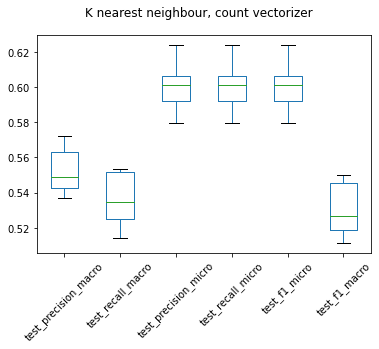

In [35]:
kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, count vectorizer')
plt.show()

What happens if we try another classifier? Let's try a random forest classifier.

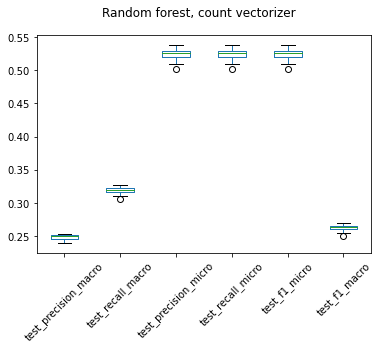

In [36]:
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(rf_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Random forest, count vectorizer')
plt.show()

Was this better or worse? Are there any parameters worth changing?

# 6: Another representation model: Tf-idf
We have used a very simple bag-of-words representation. What happens if we try something else? Let's try tf-idf. This is considered a strong baseline in many text classification tasks.

In [37]:

stopWords = set(stopwords.words('english'))
tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
second_fit_transformed_data =  tfidf_vect.transform(trainingdata['txt'])
second_fit_transformed_data

<25000x32025 sparse matrix of type '<class 'numpy.float64'>'
	with 413839 stored elements in Compressed Sparse Row format>

What other parameters can you change in this representation? How does this look different from the CountVectorizer representation?

Let's now use this with the Multinomial Naive Bayes classifier.

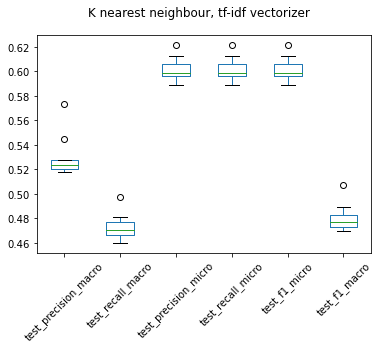

In [38]:
kneighbour_classifier = KNeighborsClassifier().fit(second_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, second_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, tf-idf vectorizer')
plt.show()

This looks better, doesn't it? Why do you think this works better?

# 7: Representations: embeddings

Last week, you learnt about embedding representations. What might be the benefit of using this type of representation instead of counts or tf-idf?

As you saw, there are many pre-trained embedding models available online. Let's try using one of these on this data. 

Zeugma is a package where you can use embeddings in sklearn.
https://github.com/nkthiebaut/zeugma

It allows you to directly download pre-trained models that have been released from the gensim website.


Let's use a basic glove model.

In [39]:
glove = EmbeddingTransformer('glove')


[==================================================] 100.0% 104.8/104.8MB downloaded


We now need to transform our training data to map to this embedding model.

In [40]:
glove_transformed_training_data = glove.transform(trainingdata['txt'])

Have a look at what the data now looks like with this representation

In [41]:
glove_transformed_training_data

array([[-0.00688767,  0.11176454, -0.45859256, ..., -0.29871118,
        -0.33164892, -0.2711602 ],
       [-0.10364454,  0.23297037, -0.5598883 , ..., -0.22309318,
        -0.03964619, -0.34247562],
       [ 0.08953218,  0.21429771, -0.47121647, ..., -0.29645458,
        -0.0654586 , -0.34297094],
       ...,
       [ 0.0240526 ,  0.26602852, -0.19162774, ...,  0.06743708,
        -0.098058  , -0.3533837 ],
       [-0.0421645 ,  0.32998252, -0.31218937, ..., -0.46439838,
         0.0401425 , -0.35525286],
       [-0.09711062,  0.28295168, -0.5921539 , ..., -0.36167938,
        -0.5108108 , -0.16480824]], dtype=float32)

Let's build a classifier with this representation and evaluate with 10-fold cross-validation.

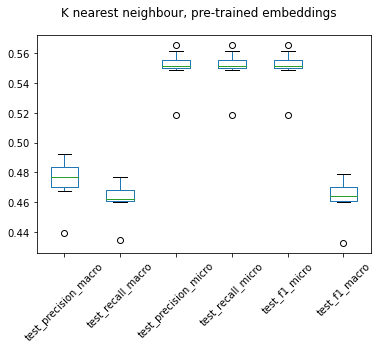

In [42]:
kneighbour_classifier = KNeighborsClassifier().fit(glove_transformed_training_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, glove_transformed_training_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, pre-trained embeddings')
plt.show()

What do you think about these results? What is happening here?

There are a number of pre-trained embedding models that have been released openly, a full list of pretrained embeddings to experiment with using this library: https://github.com/RaRe-Technologies/gensim-data#models

You can play with these if you want, e.g.:
glove = EmbeddingTransformer('glove-wiki-gigaword-50')

# 8: Classifiers, representations, evaluation

You've now seen that you get very different results depending on which representation you use, which classifier, and also that there are many different metrics to analyse.

Let's try some different configurations all in one go. We'll create a dictionary with the three different types of representations, and a list of different classification algorithms, and apply all these configurations to see what seems to yield best results according to a chosen evaluation metric using 10-fold cross validation.

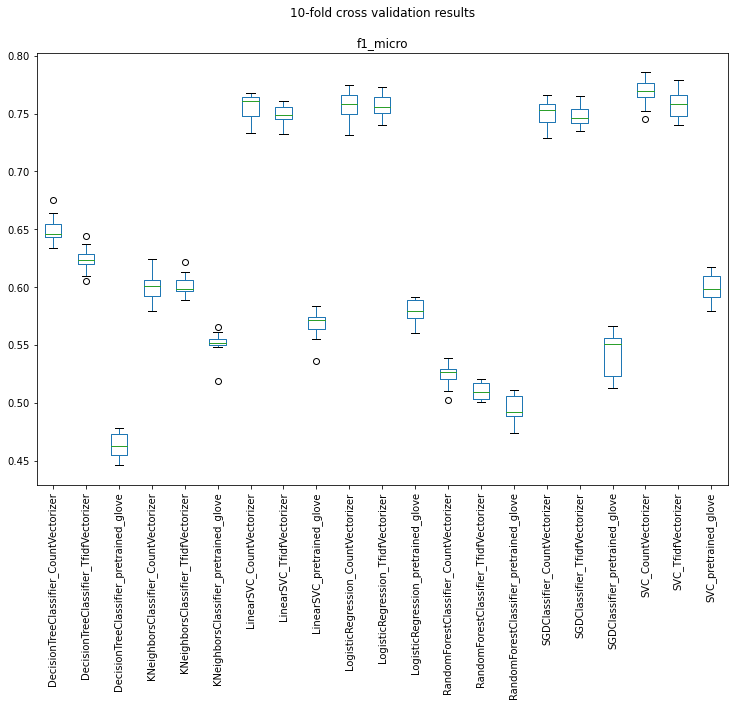

In [43]:

representations = {}

vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
xtrain_countvect = vectorizer.fit_transform(trainingdata['txt'])
representations['CountVectorizer'] = xtrain_countvect

tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
xtrain_tfidf =  tfidf_vect.transform(trainingdata['txt'])
representations['TfidfVectorizer'] = xtrain_tfidf

x_train_glove = glove.transform(trainingdata['txt'])
representations['pretrained_glove'] = x_train_glove



CV = 10

classifier_models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        DecisionTreeClassifier(),
        SVC(),
        LinearSVC(multi_class='ovr', C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      penalty='l2', random_state=0, tol=1e-05, verbose=0),
        SGDClassifier(),
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
]

cv_df = pd.DataFrame(index=range(CV * (len(classifier_models)*len(representations))))
entries = []


for representation, transformed_vector in representations.items():
    score = 'f1_micro'
    for model in classifier_models:
      model_name = model.__class__.__name__+'_'+representation
      accuracies = cross_val_score(model, transformed_vector, trainingdata['label'], scoring=score, cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', score])
bp = cv_df.boxplot(by='model_name', column=[score], grid=False, rot=90, figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('10-fold cross validation results')
plt.show()

What conclusions do you draw from this? Which classifier and which representation would you choose as your final model? Why?

# Assignment 1: Your turn to build a classifier

Answer questions by placing your code in the code cell below, running it to provide output, and giving your written answers in this markdown cell

**1.1 Choose one classifier and one representation format and test it on the blind test data. What do you think about your results, and how do they relate to the 10-fold cross validation results above?** 

**1.2 What other configurations could you try before deciding on a final model?**

**1.3 Is it appropriate to experiment with this on the test data? Why or why not?** 

In [ ]:
## PUT YOUR CODE ANSWERS IN HERE, AND RUN IT TO GIVE OUTPUT
## First step: Transform your training and test data to your chosen representation. 

## choose a representation: CountVectorizer or TfidfVectorizer, or embeddings

chosen_representation = 

## transform the training data 
transformed_training_data = chosen_representation.transform(trainingdata['txt'])

## transform the test data
transformed_test_data = chosen_representation.transform(testdata['txt'])

## Second step: Create a classifier - the one you think gave best results when experimenting with cross-validation


chosen_classifier = 

## train the classifier on the training data
chosen_classifier.fit(transformed_training_data, trainingdata['label'])
## predict labels on the test data
predicted = chosen_classifier.predict(transformed_test_data)
## what results do you get? Note that you can look at both macro and micro scores!
print(metrics.classification_report(testdata['label'], predicted, target_names=set(testdata['label'].tolist())))

# Assignment 2: use your classifier to predict labels on unseen text

Answer questions by placing your code in the three code cells below, running it to provide output, and giving your written answers in this markdown cell

**What happens if you try to predict a label with a completely new text using your chosen trained classifier model? Does it seem to classify correctly?**

In [ ]:
new_text = 'Patient with severe depression.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

In [ ]:
new_text = '5-year old girl with asthma.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

In [ ]:
new_text = 'Her pain is severe.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

# Assignment 3: Evaluation

**Write ten example sentences or paragraphs where you assign the correct label to each of them. Then pass them to the classifier and calculate precision, recall and f-score, by completing the skeleton code in the cell below, and running it to give output. Analyse and discuss the results, giving your answer in this markdown cell.**

***Gold label values: psychiatrypsychology, hematology, pain, pediatrics***

In [ ]:
new_text = []
new_gold_labels = ['pain', 'pain', 'pediatrics', 'hematology', 'psychiatrypsychology', 'pediatrics', 'psychiatrypsychology', 'hematology', 'pain', 'psychiatrypsychology']
testX = chosen_representation.transform(new_text)
predicted = chosen_classifier.predict(testX)
## compare the predicted labels with the gold labels. HINT: metrics.classification_report is useful here
print(predicted)

print(metrics.classification_report(new_gold_labels, predicted, target_names=set((new_gold_labels))))


You've now experimented with different respresentations for text classification, different classification algorithms, and experimental setups.

There are many other alternative approaches available today.


For instance, there are pre-trained biomedical embeddings, trained on scientific literature, one example: https://www.aclweb.org/anthology/W16-2922.pdf
https://github.com/cambridgeltl/BioNLP-2016

There are also many online resources with additional examples and ideas, here's one example: https://towardsdatascience.com/text-classification-in-python-dd95d264c802